 # Time series forecasting - Neural prophet
 Neural prophet is a time series forecasting library very similar to the Facebook prophet.
 Neural prophet runs using `pytorch`, rather than `fbprophet` and it's use of `pystan`.
 It has some potential advantages by using stochastic gradient descent.

 Here we see how fast it is to fit and predict models with the two time series.
 Then we compare the model performances.

 To start, import some relevant libraries:

In [1]:
import numpy as np
import pandas as pd
from time import process_time, time
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.WARNING)

from fbprophet import Prophet
from neuralprophet import NeuralProphet

from pathlib import Path
import sys

sys.path.insert(0, str(Path(os.getcwd()).parent / "utilities"))
import utilities
import data

ERROR:fbprophet.plot:Importing plotly failed. Interactive plots will not work.


 The data used for this experiment is weather data - daily temperatures over a few years with no other covariates.
 We format the data appropriately for the Facebook Prophet API,
 with a datetime column `ds` and an output column `y`.
 We split the data into the usual train and test sets.

,ds,y
0,2009-01-02,-4.54
1,2009-01-03,-4.71
2,2009-01-04,-1.90
3,2009-01-05,-1.47
4,2009-01-06,-12.63
5,2009-01-07,-21.09
6,2009-01-08,-10.78
7,2009-01-09,-13.91
8,2009-01-10,-13.24
9,2009-01-11,-10.75


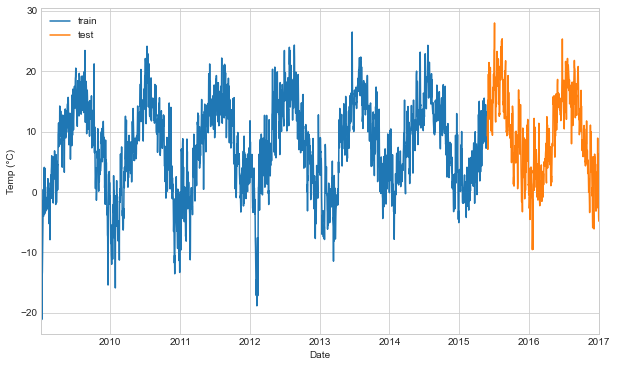

In [2]:
df = data.get_weather_data()
df_train, df_test = utilities.split_ts(df)

ax = df_train["y"].plot(figsize=(10, 6), label="train")
df_test["y"].plot(ax=ax, label="test")
ax.legend()
ax.set_xlabel("Date")
ax.set_ylabel("Temp (°C)")

df_train = df_train.reset_index()
df_test = df_test.reset_index()

df_train.head(10)

 ## How fast is `neuralprophet`?
 We train a default `fbprophet` model 10 times and measure the computation time for each.
 For each model we predict the test set and time that too.

In [3]:
logger = logging.getLogger('fbprophet')
logger.setLevel(logging.WARNING)

trials = 10
fit_time = []
predict_time = []
for ii in range(trials):
    t1 = process_time()
    model_prophet = Prophet()
    model_prophet.fit(df_train)
    fit_time.append(process_time() - t1)

    t1 = process_time()
    df_pred_prophet = model_prophet.predict(df_test)
    predict_time.append(process_time() - t1)

 We do the same for `neuralprophet`.
 The API is essentially the same as `prophet` so it's easy to switch in.
 We set the number of changepoints to the same as the `fbprophet` default of 25.
 The time spent training is dependent on the number of epochs we train for.
 The default number is a function of the data length, but can be manually overridden.

In [4]:
fit_time_neural = []
predict_time_neural = []
for ii in range(trials):
    t1 = process_time()
    model_nprophet = NeuralProphet(
        trend_reg=1.0,
        n_changepoints=25,
        log_level='WARNING'
    )
    model_nprophet.fit(df_train, freq="D")
    fit_time_neural.append(process_time() - t1)

    t1 = process_time()
    future_nprophet = model_nprophet.make_future_dataframe(
        df=df_train.iloc[[-1]],
        periods=df_test.shape[0],
    )
    df_pred_nprophet = model_nprophet.predict(future_nprophet)
    predict_time_neural.append(process_time() - t1)

 90%|█████████ | 90/100 [00:00<00:00, 517.98it/s]


 ### Plotting results
 Neural prophet is a fair bit slower to train, but significantly faster for predicting.

<ipython-input-5-6be12f8e0324>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


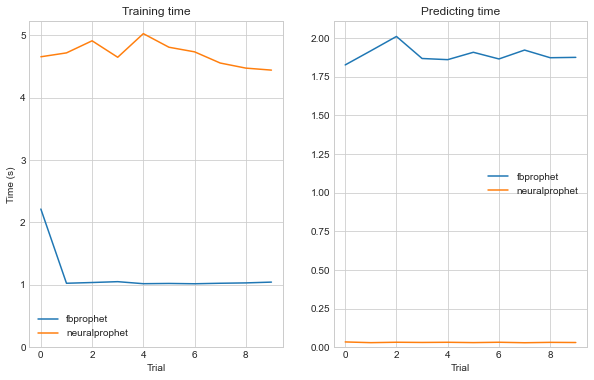

In [5]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 6))
ax[0].plot(fit_time, label="fbprophet")
ax[0].plot(fit_time_neural, label="neuralprophet")
ax[0].legend()
ax[0].set_xlabel("Trial")
ax[0].set_ylabel("Time (s)")
ax[0].set_ylim(0)
ax[0].set_title("Training time")

ax[1].plot(predict_time, label="fbprophet")
ax[1].plot(predict_time_neural, label="neuralprophet")
ax[1].legend()
ax[1].set_xlabel("Trial")
ax[1].set_ylim(0)
ax[1].set_title("Predicting time")
fig.show()

 ## Model results
 The resulting predictions and model components are similar between the two models.
 The underlying models are not identical, as such I don't expect identical predictions.

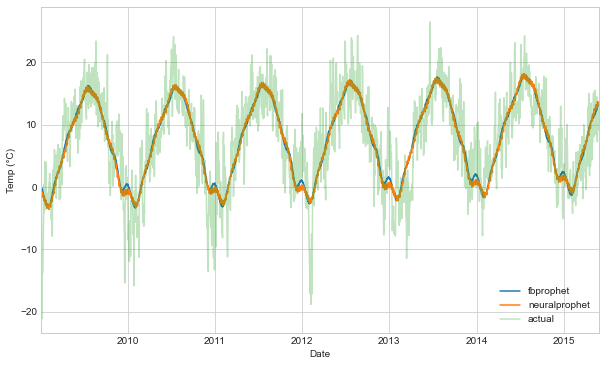

In [6]:
# generate training predictions
df_pred_prophet_train = model_prophet.predict(df_train)

future_nprophet = model_nprophet.make_future_dataframe(
    df=df_train.iloc[[0]],
    periods=df_train.shape[0],
)
df_pred_nprophet_train = model_nprophet.predict(future_nprophet)

# plot results
ax = df_pred_prophet_train.set_index("ds")["yhat"].plot(
    figsize=(10, 6), label="fbprophet"
)
df_pred_nprophet_train.set_index("ds")["yhat1"].plot(ax=ax, label="neuralprophet")
df_train.set_index("ds")["y"].plot(ax=ax, label="actual", alpha=0.3)
ax.legend()
ax.set_xlabel("Date")
ax.set_ylabel("Temp (°C)")
plt.show()

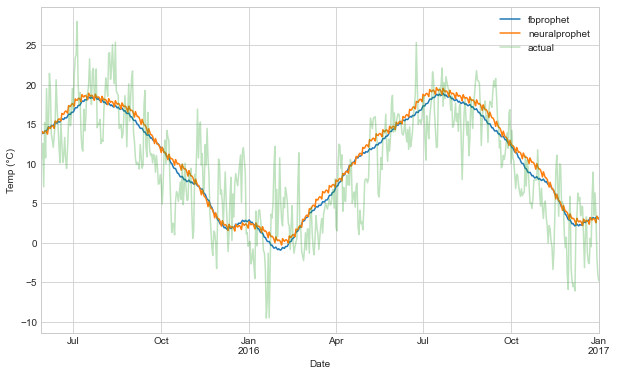

In [7]:
# test performance
ax = df_pred_prophet.set_index("ds")["yhat"].plot(
    figsize=(10, 6), label="fbprophet"
)
df_pred_nprophet.set_index("ds")["yhat1"].plot(ax=ax, label="neuralprophet")
df_test.set_index("ds")["y"].plot(ax=ax, label="actual", alpha=0.3)
ax.legend()
ax.set_xlabel("Date")
ax.set_ylabel("Temp (°C)")
plt.show()

 Both models decompose to give seasonal components. They are similar between the two.
 Note the weekly seasonality scale is small - we wouldn't expect temperature to have a weekly seasonality at all.

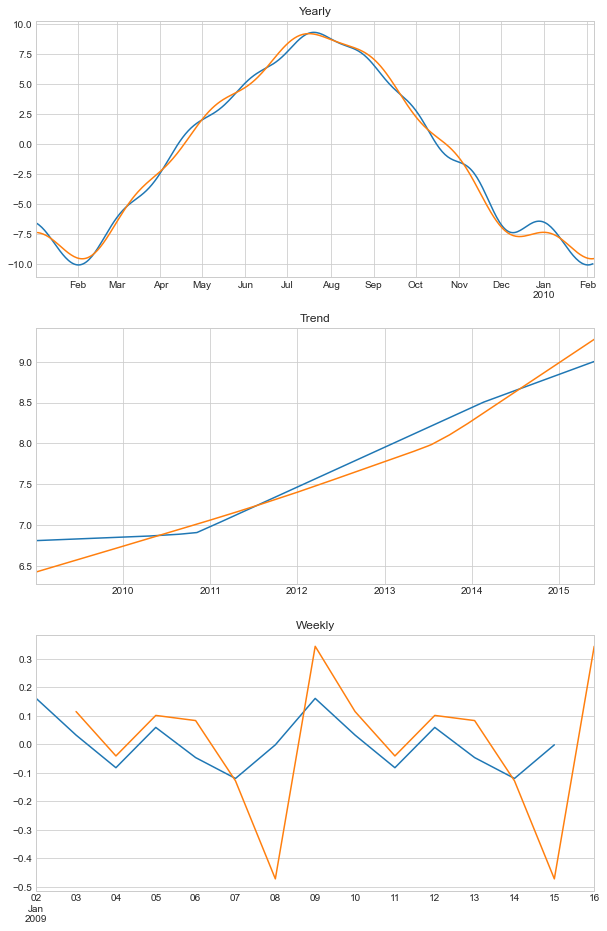

In [8]:
fig, ax = plt.subplots(nrows=3, figsize=(10,16))
df_pred_prophet_train.set_index("ds").iloc[:400]["yearly"].plot(ax=ax[0], label="prophet")
df_pred_nprophet_train.set_index("ds").iloc[:400]["season_yearly"].plot(ax=ax[0], label="neuralprophet")
ax[0].set_title('Yearly')
ax[0].set_xlabel('')

df_pred_prophet_train.set_index("ds")["trend"].plot(ax=ax[1], label="prophet")
df_pred_nprophet_train.set_index("ds")["trend"].plot(ax=ax[1], label="neuralprophet")
ax[1].set_title('Trend')
ax[1].set_xlabel('')

df_pred_prophet_train.set_index("ds").iloc[:14]["weekly"].plot(ax=ax[2], label="prophet")
df_pred_nprophet_train.set_index("ds").iloc[:14]["season_weekly"].plot(ax=ax[2], 
    label="neuralprophet"
)
ax[2].set_title('Weekly')
ax[2].set_xlabel('')
plt.show()